In [7]:
import os
import time
import h5py
import numpy as np
from sklearn.svm import *
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import Normalizer
from sklearn.metrics import roc_auc_score

In [8]:
# b_h5 = '/eos/cms/store/user/fsiroky/hdf5_data/'
# b_h5 = '/mnt/hdf5test/'
b_h5   = '/home/test_local/'

pds  = {1: 'BTagCSV', 2: 'BTagMu', 3: 'Charmonium', 4:'DisplacedJet', 5: 'DoubleEG',
        6: 'DoubleMuon', 7: 'DoubleMuonLowMass',
       # 8: 'FSQJets', 9: 'HighMultiplicityEOF', #NOT ENOUGH DATA, NOTEBOOK FAILES
        10: 'HTMHT', 11: 'JetHT', 12: 'MET',
       # 13: 'MinimumBias', #NOT ENOUGH DATA
        14: 'MuonEG', 15: 'MuOnia',
       # 16: 'NoBPTX',
        17: 'SingleElectron', 18: 'SingleMuon', 19: 'SinglePhoton', 20: 'Tau', 21: 'ZeroBias'
}
print(len(pds))
nbr = 1

bg_files  = [b_h5+pds[nbr]+'_C_background.h5',b_h5+pds[nbr]+'_D_background.h5', b_h5+pds[nbr]+'_E_background.h5',
             b_h5+pds[nbr]+'_F_background.h5', b_h5+pds[nbr]+'_G_background.h5', b_h5+pds[nbr]+'_H_background.h5']

bg_jets   = [pds[nbr]+"_C_background", pds[nbr]+"_D_background", pds[nbr]+"_E_background",
             pds[nbr]+"_F_background", pds[nbr]+"_G_background", pds[nbr]+"_H_background"]

sig_files = [b_h5+pds[nbr]+'_C_signal.h5',b_h5+pds[nbr]+'_D_signal.h5', b_h5+pds[nbr]+'_E_signal.h5',
             b_h5+pds[nbr]+'_F_signal.h5', b_h5+pds[nbr]+'_G_signal.h5', b_h5+pds[nbr]+'_H_signal.h5']

sig_jets  = [pds[nbr]+"_C_signal", pds[nbr]+"_D_signal", pds[nbr]+"_E_signal",
             pds[nbr]+"_F_signal", pds[nbr]+"_G_signal", pds[nbr]+"_H_signal"]



      
def get_jets(bg_files, bg_jets, sig_files, sig_jets):
    good_jets = np.empty([0,2802])
    bad_jets  = np.empty([0,2802])
    np.random.seed(24)
    for i in range(len(bg_files)-4):
        try:
            bg_jetfile  = h5py.File(bg_files[i],'r')
            bg_jet      = bg_jetfile[bg_jets[i]][:]
            sig_jetfile = h5py.File(sig_files[i],'r')
            sig_jet     = sig_jetfile[sig_jets[i]][:]

            bad_jets    = np.concatenate((bad_jets, bg_jet), axis=0)
            good_jets = np.concatenate((good_jets, sig_jet), axis=0)
            print(len(bg_jet),  len(sig_jet)) #FIX HERE

        except OSError:
            print("This Primary Dataset doesn't have ", bg_jets[i])
    return good_jets, bad_jets

def get_train_test_split(good_jets, bad_jets, test_size_ratio):
    x_train = np.concatenate((good_jets,bad_jets), axis=0)
    scaler = Normalizer()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)

    y_train = np.zeros(len(x_train))
    y_train[0:len(good_jets)]=1
    mask = shuffle((np.arange(len(x_train))), random_state=42)

    x_train = x_train[mask]
    y_train = y_train[mask]

    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size_ratio, random_state=42)
    return x_train, x_test, y_train, y_test

17


In [9]:


good_jets, bad_jets = get_jets(bg_files, bg_jets, sig_files, sig_jets)
x_train, x_test, y_train, y_test = get_train_test_split(good_jets, bad_jets, test_size_ratio=0.15)
# x_train, x_val, y_train, y_val   = train_test_split(x_train, y_train, test_size=0.15, random_state=1)
print(x_train)
print(x_test)
del(good_jets)
del(bad_jets)

sigInd     = np.where(y_train==1)
backInd    = np.where(y_train==0)

sigIndTest  = np.where(y_test==1)
backIndTest = np.where(y_test==0) 

sigVals    = x_train[sigInd]
backVals   = x_train[backInd]
sigTarget  = y_train[sigInd]
backTarget = y_train[backInd]
del(x_train)
del(y_train)

sigValsTest    = x_test[sigIndTest]
backValsTest   = x_test[backIndTest] 
sigTargetTest  = y_test[sigIndTest]
backTargetTest = y_test[backIndTest]
del(x_test)
del(y_test)

X_outliers = np.concatenate((backVals, backValsTest), axis=0)


315 13568
138 27151
[[  8.12587693e-05   1.62688207e-04   2.72205659e-05 ...,   1.71019092e-05
    6.89707631e-02   9.65590684e-01]
 [  9.98850415e-05   2.12585522e-04   2.99462851e-05 ...,   1.88124946e-05
    7.63460920e-02   9.92499261e-01]
 [  8.71187095e-05   1.71776221e-04   2.92519850e-05 ...,   1.83786394e-05
    7.07142961e-02   9.90000122e-01]
 ..., 
 [  1.07564775e-04   2.19287995e-04   3.59651565e-05 ...,   2.25926536e-05
    7.61886195e-02   9.90452082e-01]
 [  7.51688294e-05   1.57751984e-04   2.46976985e-05 ...,   1.55149653e-05
    6.67604012e-02   9.34645607e-01]
 [  9.27216767e-05   1.87667305e-04   3.06596988e-05 ...,   1.92619551e-05
    7.62625309e-02   9.91412896e-01]]
[[  1.07640855e-04   2.26488437e-04   3.52367266e-05 ...,   2.21389482e-05
    7.63458455e-02   9.92495984e-01]
 [  1.10914465e-04   2.43690981e-04   3.35233240e-05 ...,   2.10564565e-05
    7.62490260e-02   9.91237377e-01]
 [  8.15658814e-05   1.59530510e-04   2.75447619e-05 ...,   1.73062363e-05
 

In [6]:
whos

Variable               Type        Data/Info
--------------------------------------------
LinearSVC              type        <class 'sklearn.svm.classes.LinearSVC'>
LinearSVR              ABCMeta     <class 'sklearn.svm.classes.LinearSVR'>
Normalizer             type        <class 'sklearn.preprocessing.data.Normalizer'>
NuSVC                  ABCMeta     <class 'sklearn.svm.classes.NuSVC'>
NuSVR                  ABCMeta     <class 'sklearn.svm.classes.NuSVR'>
OneClassSVM            ABCMeta     <class 'sklearn.svm.classes.OneClassSVM'>
SVC                    ABCMeta     <class 'sklearn.svm.classes.SVC'>
SVR                    ABCMeta     <class 'sklearn.svm.classes.SVR'>
X_outliers             ndarray     453x2802: 1269306 elems, type `float64`, 10154448 bytes (9.684036254882812 Mb)
b_h5                   str         /home/test_local/
backInd                tuple       n=1
backIndTest            tuple       n=1
backTarget             ndarray     382: 382 elems, type `float64`, 3056 byt

In [10]:
nuVal    = 0.05
gammaVal = 0.06
clf  = OneClassSVM(nu=nuVal, kernel = 'rbf', gamma = gammaVal)
clf.fit(sigVals)



OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.06, kernel='rbf',
      max_iter=-1, nu=0.05, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [11]:
y_pred_train = clf.predict(sigVals)
y_pred_test = clf.predict(sigValsTest)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

In [13]:

falseNegTrain = y_pred_train[y_pred_train == -1].size
falseNegTest = y_pred_test[y_pred_test == -1].size
falsePos = y_pred_outliers[y_pred_outliers == 1].size
truePosTrain = y_pred_train[y_pred_train == 1].size
truePosTest = y_pred_test[y_pred_test == 1].size

In [16]:
#Plots classification results for signal and background
osvmArrs = []
osvmHists = []

#Separates decision function results into signal and background
#along with training and testing
osvmArrs.append(clf.decision_function(sigVals).ravel())
osvmArrs.append(clf.decision_function(sigValsTest).ravel())
osvmArrs.append(clf.decision_function(X_outliers).ravel())



/usr/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Loss Rate                                           :  4.995904995904995
Pollution Rate                                      :  6.692406692406692
Number of errors on training set :  1731  Percentage:  5.0008667013347194
Number of errors on test set     :  305  Percentage:  4.995904995904995
Number of errors on outliers set :  416   Percentage:  91.83222958057395


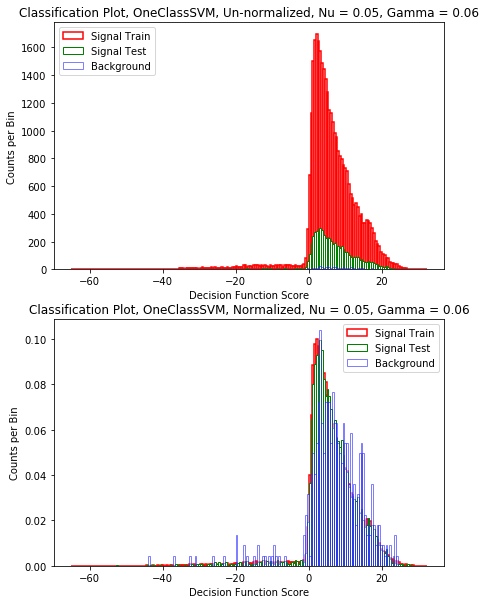

In [21]:
#%jsroot on9
%matplotlib inline
matplotlib.use('Agg')

#Sets up plot boundaries
plotMin = min(min(osvmArrs[0]), min(osvmArrs[1]), min(osvmArrs[2]))
plotMax = max(max(osvmArrs[0]), max(osvmArrs[1]), max(osvmArrs[2]))
binz = np.linspace(plotMin, plotMax, 200)

#Creates first histogram of Un-normalized Classification
plt.figure(figsize=(7, 10))
plt.subplot(211)
plt.hist(osvmArrs[0], normed = False, bins = binz, edgecolor = 'red',   
         facecolor = 'white', alpha=1, label = "Signal Train", linewidth = 1.5)
plt.hist(osvmArrs[1], normed = False, bins = binz, edgecolor = 'green', 
         facecolor = 'white', alpha=1, label = "Signal Test")
plt.hist(osvmArrs[2], normed = False, bins = binz, edgecolor = 'blue',  
         facecolor = 'white', alpha=.5, label = "Background")
plt.title("Classification Plot, OneClassSVM, Un-normalized, Nu = %s, Gamma = %s" % (nuVal,gammaVal))
plt.xlabel("Decision Function Score")
plt.ylabel("Counts per Bin")
plt.legend(loc = "upper left")

#Creates second histogram of Normalized Classification
plt.subplot(212)
plt.hist(osvmArrs[0], normed = True, bins = binz, edgecolor = 'red',   
         facecolor = 'white', alpha=1, label = "Signal Train", linewidth = 1.5)
plt.hist(osvmArrs[1], normed = True, bins = binz, edgecolor = 'green', 
         facecolor = 'white', alpha=1, label = "Signal Test")
plt.hist(osvmArrs[2], normed = True, bins = binz, edgecolor = 'blue',  
         facecolor = 'white', alpha=.5, label = "Background")
plt.title("Classification Plot, OneClassSVM, Normalized, Nu = %s, Gamma = %s" % (nuVal,gammaVal))
plt.xlabel("Decision Function Score")
plt.ylabel("Counts per Bin")
plt.legend()

#Prints relevant statistics below
print("Loss Rate                                           : ", (falseNegTest/(truePosTest+falseNegTest)*100))
print("Pollution Rate                                      : ", (falsePos/(truePosTest+falsePos))*100)
print("Number of errors on training set : ", falseNegTrain, " Percentage: ", (falseNegTrain/len(sigVals)*100))
print("Number of errors on test set     : ", falseNegTest, " Percentage: ", (falseNegTest/len(sigValsTest)*100))
print("Number of errors on outliers set : ", falsePos, "  Percentage: ", (falsePos/len(X_outliers)*100))

In [26]:
# #Creates ROC curve
# from sklearn.metrics import roc_curve
# yTest = np.append(sigTargetTest, backTarget)
# osvmScore = np.append(osvmArrs[1], osvmArrs[2])
# fpr, tpr, _ = roc_curve(yTest, osvmScore)
# roc_auc = auc(fpr, tpr)

# plt.figure()
# lw = 2;
# plt.plot(fpr, tpr, color='darkorange',
#         lw = lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw = lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC OSVM, Tuned, Nu = %s, Gamma = %s' % (nuVal,gammaVal))
# plt.legend(loc="lower right")
# plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [6487, 6558]

In [ ]:
# plot the line, the points, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-100, 100, 500), np.linspace(-100, 100, 500))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

In [ ]:
whos

In [ ]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size